In [1]:
import pandas as pd
import akshare as ak

# 800自由现金流，季度更新
# https://www.csindex.com.cn/#/indices/family/detail?indexCode=932368
stocks = [
'000039',
'000426',
'000513',
'000568',
'000651',
'000708',
'000792',
'000807',
'000858',
'000933',
'002001',
'002056',
'002120',
'002352',
'002532',
'002714',
'300002',
'300073',
'300498',
'300724',
'300803',
'600066',
'600096',
'600219',
'600258',
'600295',
'600312',
'600352',
'600380',
'600482',
'600585',
'600873',
'600938',
'600968',
'601156',
'601168',
'601212',
'601225',
'601231',
'601600',
'601877',
'601880',
'601919',
'603129',
'603233',
'603816',
'603833',
'603885',
'603939',
'603993'
]
# 一次性获取全市场 A 股实时行情
spot_df = ak.stock_zh_a_spot_em()

/home/jovyan/data/.venv/lib/python3.11/site-packages/py_mini_racer/py_mini_racer.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


  0%|          | 0/57 [00:00<?, ?it/s]

In [2]:
# 只看我们关心的列
spot_df = spot_df[["代码", "名称", "流通市值"]]

# 过滤出你的股票
my_df = spot_df[spot_df["代码"].isin(stocks)]

In [3]:
def weekly_return(code):
    try:
        df = ak.stock_zh_a_hist(symbol=code, period="weekly", adjust="hfq")
        if len(df) >= 2:
            last_week_close = df.iloc[-2]["收盘"]
            this_week_close = df.iloc[-1]["收盘"]
            return round((this_week_close / last_week_close - 1) * 100, 2)
    except Exception as e:
        print(f"{code} 获取失败: {e}")
    return None

# 添加周涨幅
my_df["周涨幅(%)"] = my_df["代码"].apply(weekly_return)

/tmp/ipykernel_19706/1229572994.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_df["周涨幅(%)"] = my_df["代码"].apply(weekly_return)


In [4]:
my_df["市值_score"] = pd.qcut(my_df["流通市值"], 5, labels=[5,4,3,2,1]).astype(int)
my_df["周涨幅_score"] = pd.qcut(my_df["周涨幅(%)"], 5, labels=[5,4,3,2,1]).astype(int)

# 综合得分（简单相加，也可以加权）
my_df["因子总分"] = my_df["市值_score"] + my_df["周涨幅_score"]

# 排序看前10个
result = my_df.sort_values("因子总分", ascending=False).head(10)
result

/tmp/ipykernel_19706/2716460985.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_df["市值_score"] = pd.qcut(my_df["流通市值"], 5, labels=[5,4,3,2,1]).astype(int)
/tmp/ipykernel_19706/2716460985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_df["周涨幅_score"] = pd.qcut(my_df["周涨幅(%)"], 5, labels=[5,4,3,2,1]).astype(int)
/tmp/ipykernel_19706/2716460985.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,代码,名称,流通市值,周涨幅(%),市值_score,周涨幅_score,因子总分
2822,600380,健康元,2.361824e+10,0.29,5,5,10
4930,603233,大参林,1.942875e+10,-1.13,5,5,10
4101,002120,韵达股份,2.426637e+10,-0.50,5,5,10
2363,000039,中集集团,1.887154e+10,0.42,5,5,10
2426,600312,平高电气,2.203640e+10,0.42,5,5,10
5104,603939,益丰药房,2.921389e+10,-1.65,4,5,9
4811,300002,神州泰岳,2.613494e+10,-1.12,4,5,9
3213,600873,梅花生物,3.143773e+10,0.08,4,5,9
1035,600295,鄂尔多斯,2.046697e+10,1.53,5,3,8
2676,603885,吉祥航空,2.782423e+10,0.44,4,4,8


In [5]:
import empyrical
import alphalens as al

In [131]:
import pandas as pd
import akshare as ak
from tqdm import tqdm
import datetime as dt
import alphalens as al

# 股票池
codes = ['000039','000426','000513','000568','000651','000708','000792','000807',
         '000858','000933','002001','002056','002120','002352','002532','002714',
         '300002','300073','300498','300724','300803','600066','600096','600219',
         '600258','600295','600312','600352','600380','600482','600585','600873',
         '600938','600968','601156','601168','601212','601225','601231','601600',
         '601877','601880','601919','603129','603233','603816','603833','603885',
         '603939','603993']

start = '2018-01-02	'
end   = '2025-08-27'

tickers = codes

# ---------- 1. 拉后复权周 K ----------
def weekly_hfq(code):
    df = ak.stock_zh_a_hist(symbol=code, period="daily",
                            start_date=start.replace('-', ''),
                            end_date=end.replace('-', ''),
                            adjust="hfq")
    # 统一列名为小写英文
    df = df.rename(columns=str.lower)          # Date -> date
    df = df.rename(columns={'日期': 'date',   # 中文兜底
                            '收盘': 'close'})
    df = df[['date', 'close']].copy()
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df['code'] = code
    return df[['date', 'code', 'close']]

prices = []
for t in tqdm(tickers):
    prices.append(weekly_hfq(t))
prices = pd.concat(prices, ignore_index=True)

# 构造价格透视表：行=date, 列=code
prices_pivot = prices.pivot(index='date', columns='code', values='close')

100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


code,000039,000426,000513,000568,000651,000708,000792,000807,000858,000933,...,601877,601880,601919,603129,603233,603816,603833,603885,603939,603993
date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,441.16,181.31,310.88,1412.64,6756.69,23.40,116.55,42.48,1331.95,98.54,...,40.38,6.83,7.46,26.65,52.30,59.21,121.50,44.80,92.04,21.53
2018-01-03,437.37,187.45,319.19,1424.25,6821.88,23.31,117.27,43.27,1336.95,98.80,...,41.34,6.86,7.59,26.57,51.77,59.83,121.53,46.96,92.06,21.86
2018-01-04,438.52,191.02,332.26,1468.27,6943.14,23.57,117.93,43.66,1369.64,100.90,...,41.38,6.86,7.67,26.35,51.34,59.62,124.40,46.37,91.60,22.40
2018-01-05,431.92,184.68,329.48,1455.16,7112.64,23.40,120.48,42.33,1364.79,98.98,...,40.56,6.83,7.78,26.38,52.56,59.02,124.51,46.88,91.50,22.19
2018-01-08,443.63,194.19,328.26,1462.65,7106.13,23.66,123.17,43.62,1357.28,101.69,...,40.00,6.86,7.81,26.38,52.89,61.71,127.03,45.56,91.92,22.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-21,352.02,376.68,396.19,3081.96,8989.03,55.51,150.82,70.44,2424.60,199.94,...,43.08,4.51,29.45,289.57,54.57,66.46,92.48,39.41,162.57,36.36
2025-08-22,352.02,381.24,394.14,3101.43,9050.31,55.27,151.02,70.44,2429.91,199.76,...,43.22,4.53,29.46,288.23,54.63,66.55,92.62,39.05,162.88,36.51
2025-08-25,354.10,392.92,398.54,3256.88,9179.40,56.43,152.46,72.63,2494.66,206.14,...,43.76,4.60,29.81,285.34,54.14,68.14,95.13,39.24,160.37,39.42


In [132]:
prices.to_parquet('close.parquet', index=False)

In [164]:
import pandas as pd
import akshare as ak
from tqdm import tqdm
import time

# 中文列名到英文的映射
COLUMNS_CN_TO_EN = {
    '数据日期': 'date',
    '当日收盘价': 'close',
    '当日涨跌幅': 'change_pct',
    '总市值': 'total_market_cap',
    '流通市值': 'float_market_cap',
    '总股本': 'total_shares',
    '流通股本': 'float_shares',
    'PE(TTM)': 'pe_ttm',
    'PE(静)': 'pe_static',
    '市净率': 'pb',
    'PEG值': 'peg',
    '市现率': 'pcfr',
    '市销率': 'psr'
}

def weekly_hfq(code):
    """
    获取指定股票的估值数据（使用 ak.stock_value_em）
    返回后处理为英文列名的 DataFrame
    """
    try:
        df = ak.stock_value_em(symbol=code)
        df.rename(columns=COLUMNS_CN_TO_EN, inplace=True)
        df['date'] = pd.to_datetime(df['date'])  # 确保日期为 datetime 类型
        df['code'] = code  # 添加股票代码
        # 按日期排序
        df.sort_values('date', inplace=True)
        return df
    except Exception as e:
        print(f"Error fetching data for {code}: {e}")
        return pd.DataFrame(columns=COLUMNS_CN_TO_EN.values())

# 股票代码列表（示例，替换为你的 tickers）
tickers = codes  # 替换为你实际的股票列表

# 获取数据
prices = []
for t in tqdm(tickers, desc="Fetching stock data"):
    data = weekly_hfq(t)
    if not data.empty:
        prices.append(data)
    time.sleep(0.1)  # 控制频率，避免请求过快（原 sleep(100) 太长，可能是笔误）

# 合并所有数据
if prices:
    prices = pd.concat(prices, ignore_index=True)

    # 保存为 Parquet 文件
    prices.to_parquet('stock_valuation_data.parquet', index=False)
    print("✅ 数据已保存为 stock_valuation_data.parquet")
else:
    print("❌ 没有获取到任何数据")

Fetching stock data: 100%|██████████| 50/50 [00:30<00:00,  1.65it/s]


✅ 数据已保存为 stock_valuation_data.parquet


In [136]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.tears import create_full_tear_sheet
import warnings

warnings.filterwarnings('ignore')

# =================== 1. 加载数据 ===================
df = pd.read_parquet("stock_valuation_data.parquet", engine="pyarrow")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['code', 'date'])

# 构建宽格式
price_pivot = prices_pivot
pe_pivot = df.pivot(index='date', columns='code', values='pe_ttm')
pb_pivot = df.pivot(index='date', columns='code', values='pb')
market_cap_pivot = df.pivot(index='date', columns='code', values='total_market_cap')
float_market_cap_pivot = df.pivot(index='date', columns='code', values='float_market_cap')

pb_pivot = pb_pivot[pb_pivot > 0]
# 创建规则周频时间轴
full_weekly_dates = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='W-FRI')

def reindex_ffill(df):
    return df.reindex(full_weekly_dates, method='ffill')

price_pivot_w = reindex_ffill(price_pivot)
pe_pivot_w = reindex_ffill(pe_pivot)
pb_pivot_w = reindex_ffill(pb_pivot)
market_cap_pivot_w = reindex_ffill(market_cap_pivot)
float_market_cap_pivot_w = reindex_ffill(float_market_cap_pivot)

print(f"✅ 数据已对齐至 W-FRI，时间范围: {full_weekly_dates[0]} 到 {full_weekly_dates[-1]}")

✅ 数据已对齐至 W-FRI，时间范围: 2018-01-05 00:00:00 到 2025-08-22 00:00:00


In [176]:
# ------------------- 标准化函数 -------------------
def standardize_wide(df):
    def std_row(s):
        s_clipped = s.clip(lower=s.quantile(0.01), upper=s.quantile(0.99))
        s_mean = s_clipped.mean()
        s_std = s_clipped.std()
        return (s_clipped - s_mean) / (s_std if s_std != 0 else 1)
    return df.apply(std_row, axis=1)

# 标准化原始因子
pe_std = standardize_wide(pe_pivot_w)
pb_std = standardize_wide(pb_pivot_w)

log_mc_pivot = np.log(market_cap_pivot_w)
log_float_mc_pivot = np.log(float_market_cap_pivot_w)

def neutralize_factor(factor_df, market_cap_df, *control_dfs):
    """
    在 factor_df 的每个时间截面上，用 market_cap_df 和所有 control_dfs 的列
    对因子值做多元线性回归，并返回残差。
    """
    results = []

    for date in factor_df.index:
        try:
            y = factor_df.loc[date].dropna()
            common = y.index

            # 收集所有控制变量
            feature_list = []
            for ctrl_df in (market_cap_df,) + control_dfs:
                x = ctrl_df.loc[date].dropna()
                common = common.intersection(x.index)
                feature_list.append(x)

            if len(common) < 5:
                continue

            # 拼 X
            X = np.column_stack([np.log(feature_list[0][common])] +
                                [f[common].values for f in feature_list[1:]])
            Y = y[common].values

            model = LinearRegression().fit(X, Y)
            residual = Y - model.predict(X)
            results.append(pd.Series(residual, index=common, name=date))

        except Exception as e:
            logging.warning('Skip date %s: %s', date, e)
            continue

    if results:
        return pd.concat(results, axis=1).T
    else:
        return pd.DataFrame(index=factor_df.index, columns=factor_df.columns)

# ✅ 核心：对 PE_TTM 做「市值 + PB」双重中性化

price_std = price_pivot_w.pct_change(4 * 3) 
pe_neutralized = neutralize_factor(price_std, log_mc_pivot, pb_std, pe_std)
pe_neutralized = standardize_wide(pe_neutralized)

mc_factor_pivot = standardize_wide(log_mc_pivot)
factor_total = -pe_neutralized



# ------------------- 转为 Alphalens 所需格式 -------------------
factor_series = factor_total.stack().dropna()
factor_series.index.names = ['date', 'asset']
factor_series.name = 'factor'

print(f"📈 股票数量: {len(price_pivot_w.columns)}")
print(f"📆 交易周数: {len(price_pivot_w)}")
print(f"🔬 中性化后因子数据点数量: {len(factor_series)}")

📈 股票数量: 50
📆 交易周数: 399
🔬 中性化后因子数据点数量: 18694


Dropped 3.2% entries from factor data: 3.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 75.0%, not exceeded: OK!
✅ 因子数据处理成功!
有效数据点: 18094
📊 正在生成 Alphalens 分析报告...
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-5.189786,-0.344430,-1.438217,0.696765,3719,20.553775
2,-1.053595,0.168843,-0.384507,0.209279,3571,19.735824
3,-0.396447,0.501635,0.086126,0.161103,3566,19.708191
4,-0.042330,1.071230,0.515304,0.170087,3571,19.735824
5,0.521008,3.111155,1.247486,0.424264,3667,20.266387


Returns Analysis


,4D,8D,12D
Ann. alpha,0.054,0.126,0.087
beta,-0.007,-0.044,-0.045
Mean Period Wise Return Top Quantile (bps),22.125,23.513,18.366
Mean Period Wise Return Bottom Quantile (bps),-1.662,-9.730,-3.843
Mean Period Wise Spread (bps),23.786,32.835,21.007


<Figure size 640x480 with 0 Axes>

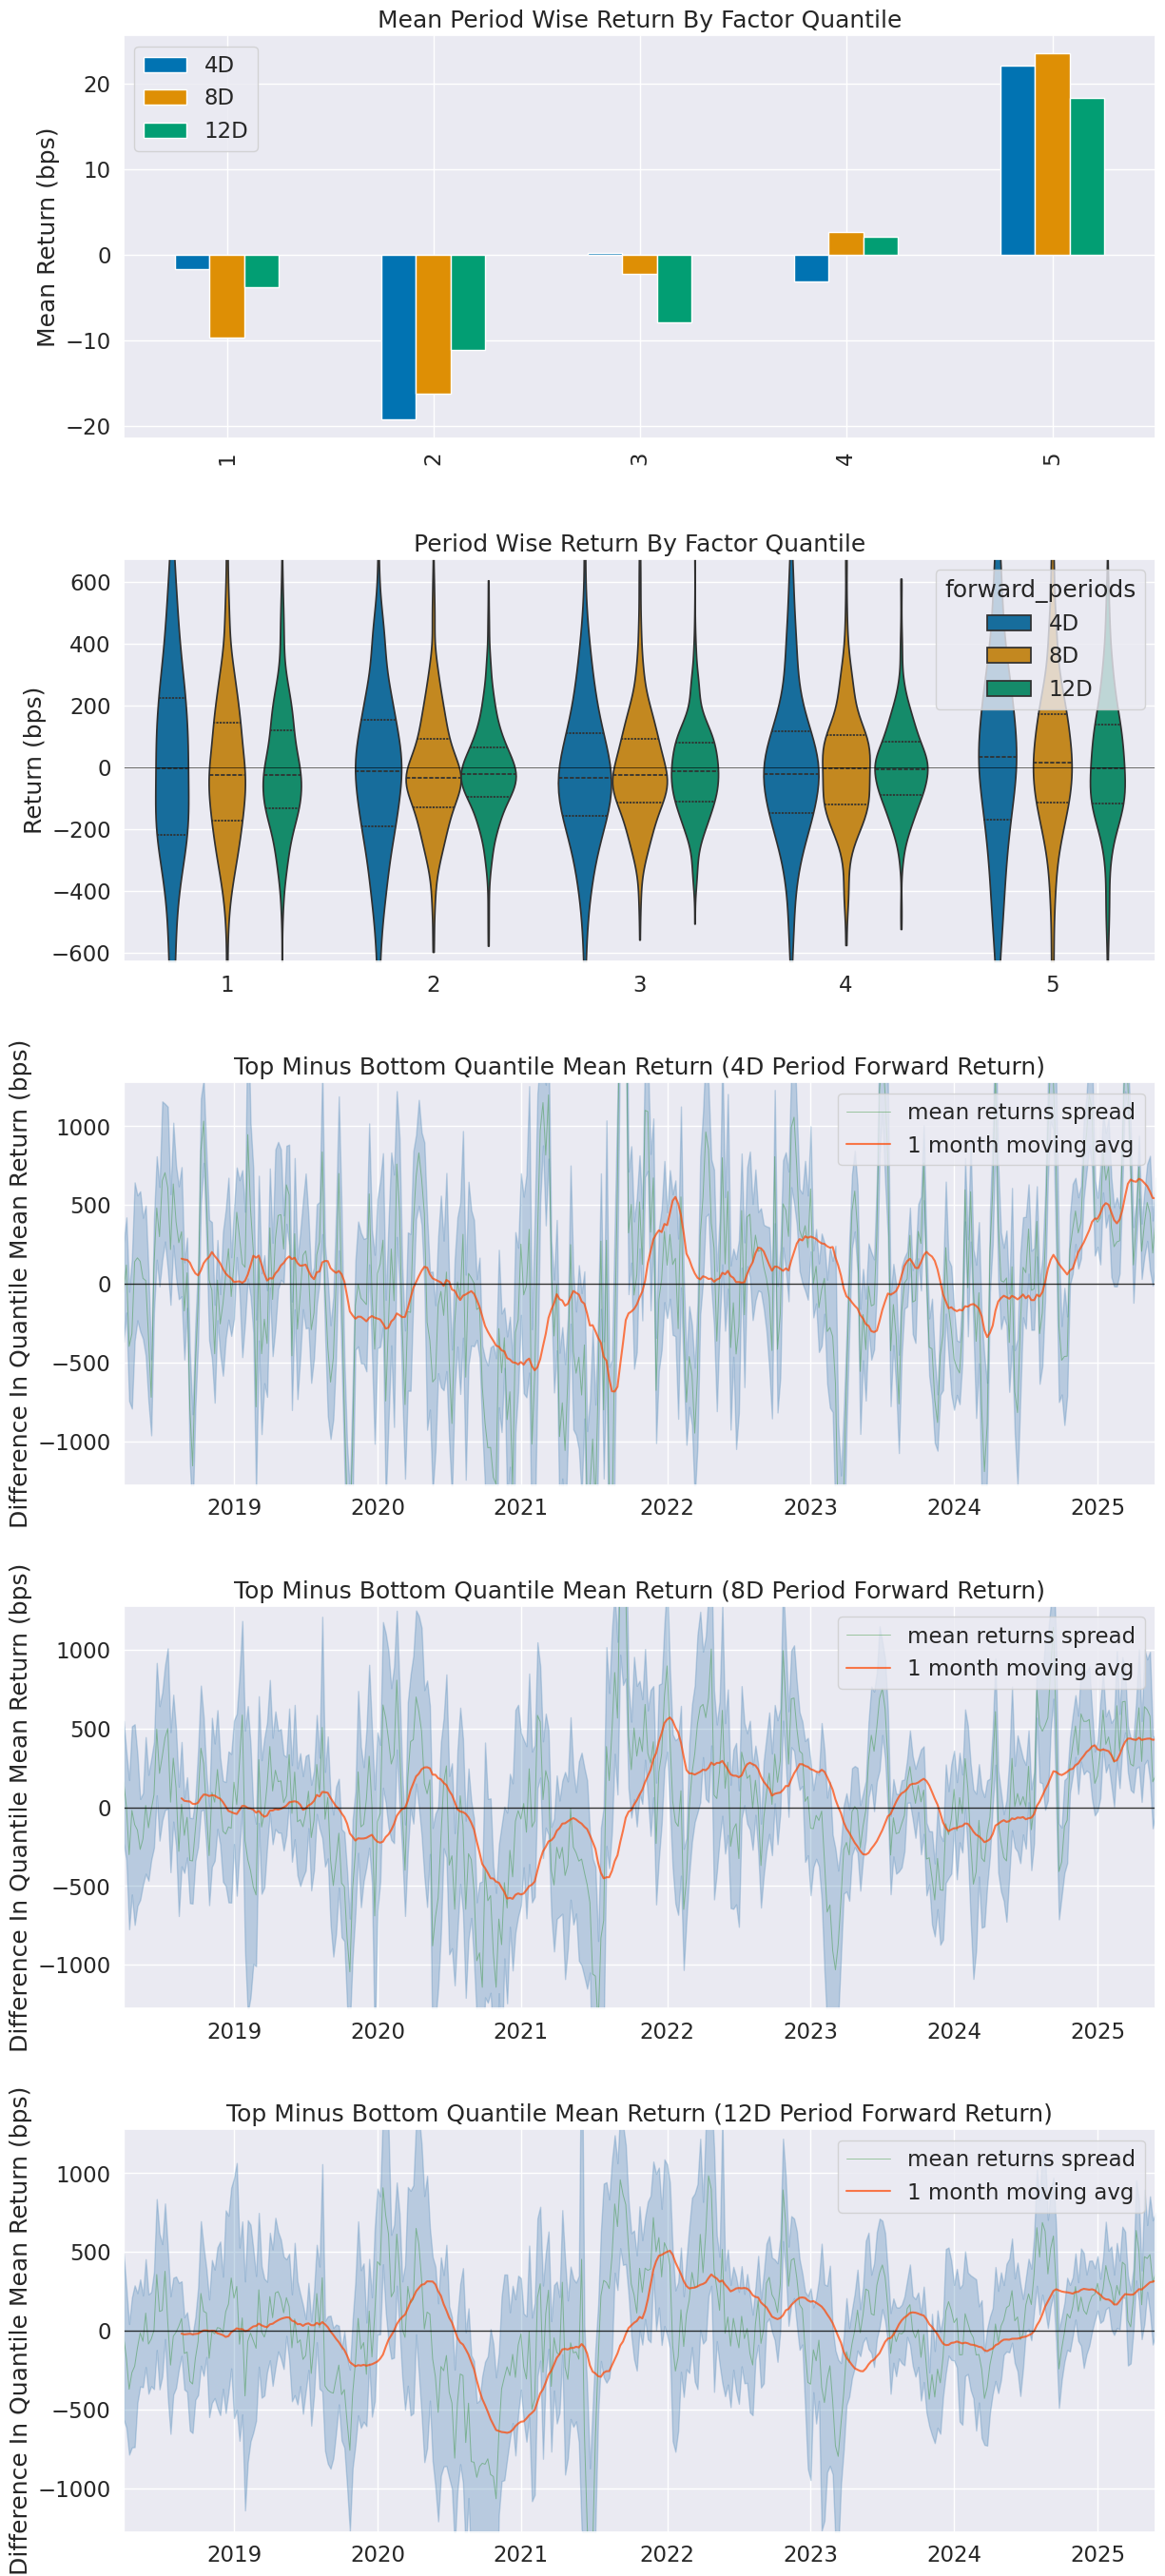

Information Analysis


,4D,8D,12D
IC Mean,0.026,0.044,0.042
IC Std.,0.239,0.241,0.228
Risk-Adjusted IC,0.111,0.182,0.186
t-stat(IC),2.148,3.521,3.605
p-value(IC),0.032,0.000,0.000
IC Skew,0.114,0.028,0.024
IC Kurtosis,-0.171,-0.599,-0.545


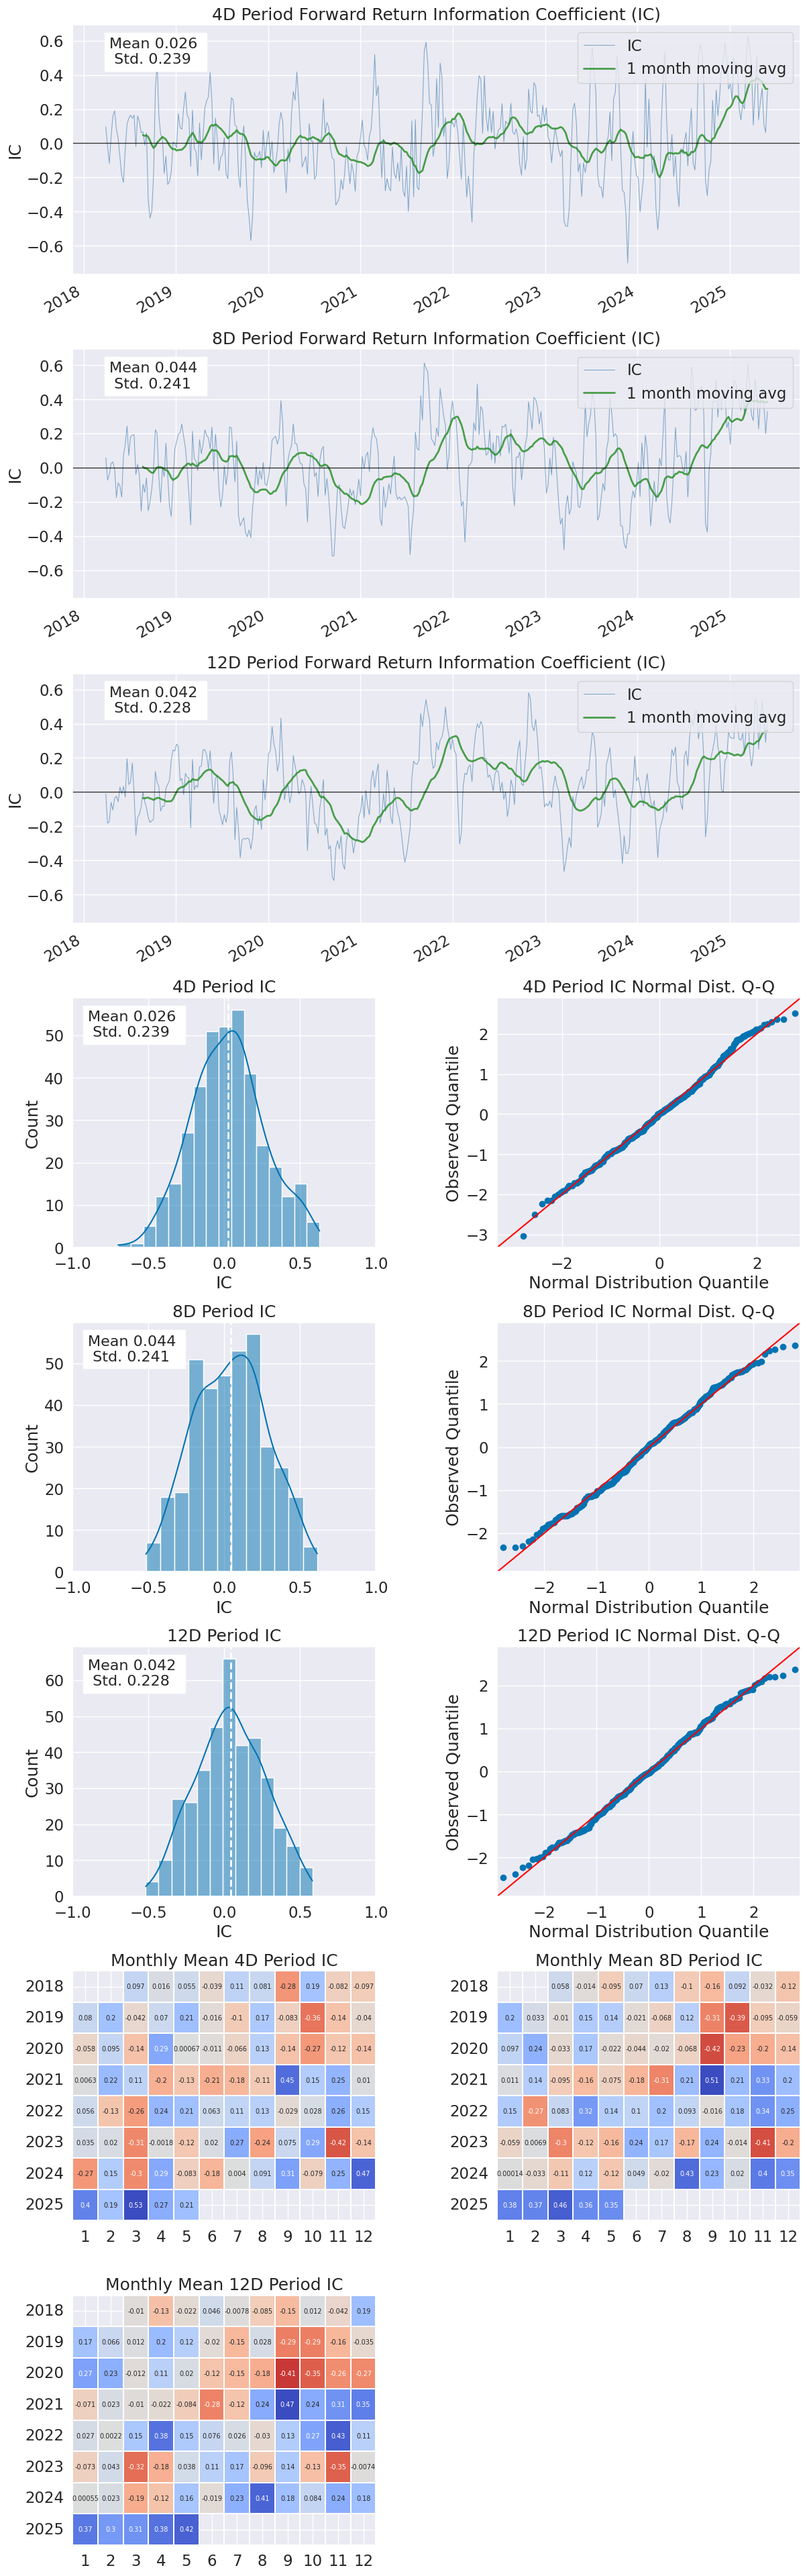

Turnover Analysis


,4D,8D,12D
Quantile 1 Mean Turnover,0.448,0.628,0.769
Quantile 2 Mean Turnover,0.684,0.747,0.802
Quantile 3 Mean Turnover,0.722,0.746,0.777
Quantile 4 Mean Turnover,0.693,0.750,0.795
Quantile 5 Mean Turnover,0.473,0.656,0.776


,4D,8D,12D
Mean Factor Rank Autocorrelation,0.597,0.27,-0.022


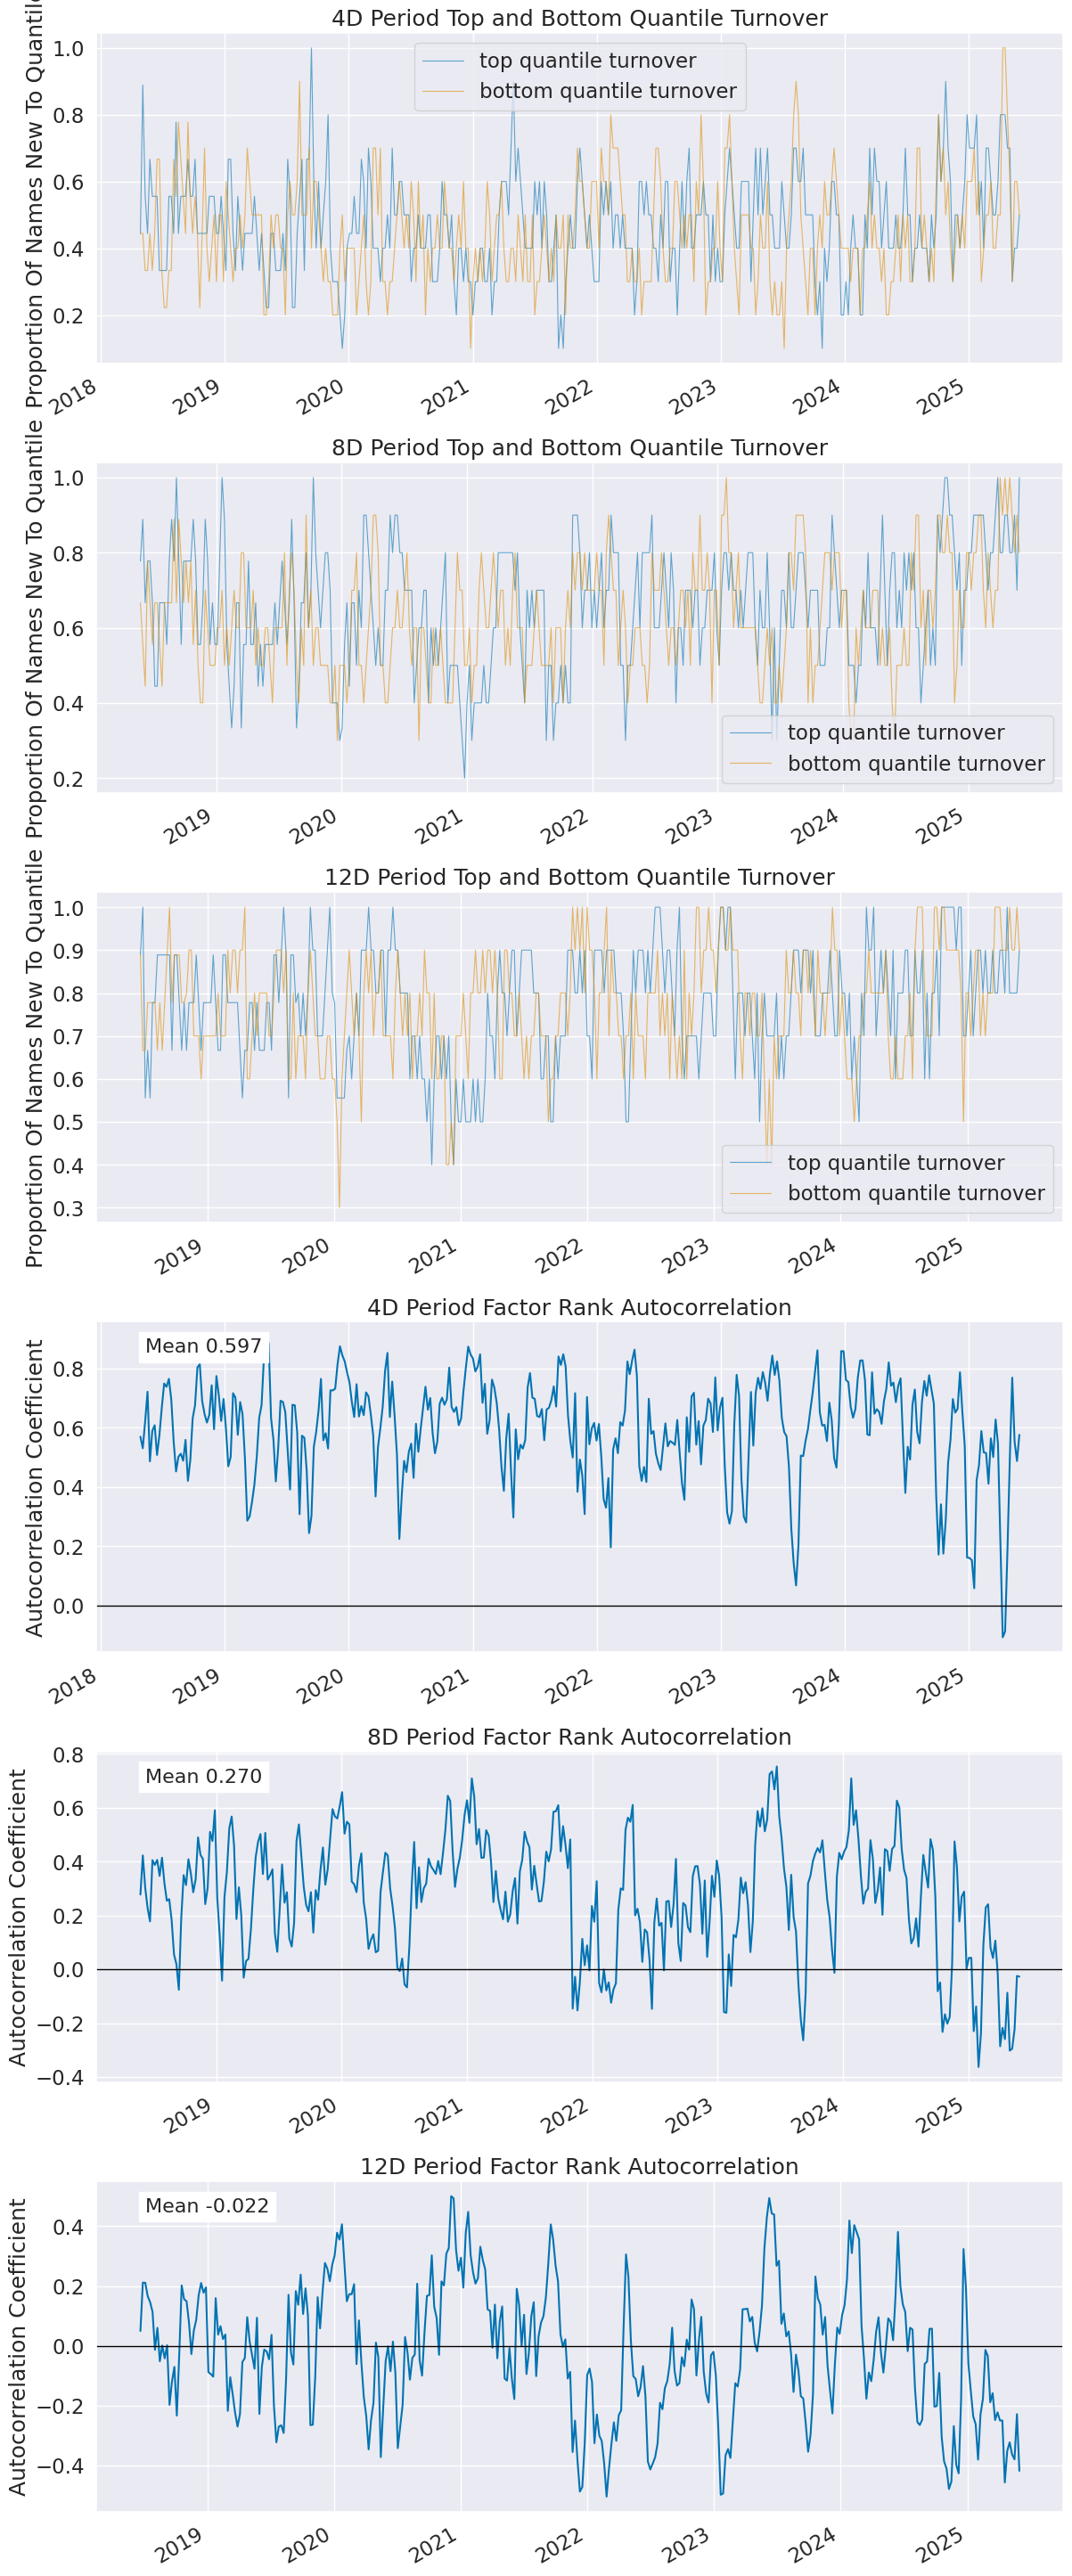

In [177]:
try:
    factor_data = get_clean_factor_and_forward_returns(
        factor=factor_series,
        prices=price_pivot_w,
        periods=[4, 8, 12],        # 4周、8周、12周前向收益
        max_loss=0.75,             # 允许 75% 数据缺失
        quantiles=5,               # 五分组
    )

    print("✅ 因子数据处理成功!")
    print(f"有效数据点: {len(factor_data)}")

    print("📊 正在生成 Alphalens 分析报告...")
    create_full_tear_sheet(
        factor_data=factor_data,
        long_short=True,        # 多空组合（推荐）
        group_neutral=False,    # 不做行业中性（可后续扩展）
        by_group=False          # 不分行业分析
    )

except Exception as e:
    print(f"❌ Alphalens 报告生成失败: {e}")
    import traceback
    traceback.print_exc()

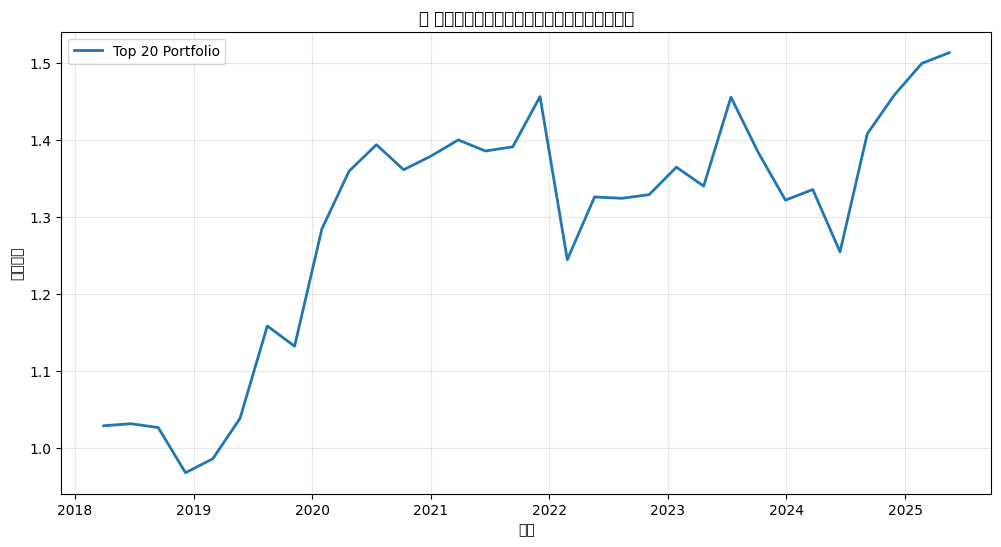

🎯 年化收益: 25.27%
📊 年化波动: 23.55%
📈 夏普比率: 1.07
📌 最大回撤: -14.55%


In [180]:
import matplotlib.pyplot as plt

# 获取下一期（如 12D）的收益
forward_returns = price_pivot.pct_change(12).shift(-12)  # 未来 12 天收益

def backtest_top_portfolio(factor_data, forward_returns, n=10, holding_period=12):
    """
    回测：每 period 选 top n，持有 holding_period 天
    """
    from datetime import timedelta

    dates = sorted(factor_data.index.get_level_values('date').unique())
    portfolio_returns = []
    for i, date in enumerate(dates):
        if i % 12 != 0:  # 每 12 周调仓一次（约每季度）
            continue

        # 选股
        factor_slice = factor_data.loc[date, 'factor']
        top_stocks = factor_slice.sort_values(ascending=False).head(n).index

        # 获取持有期收益（未来 12 天）
        end_date = date + timedelta(days=12*7)
        ret_slice = forward_returns.loc[date:end_date, top_stocks].iloc[0]  # 第一个收益

        if len(ret_slice) > 0:
            portfolio_return = ret_slice.mean()  # 等权
            portfolio_returns.append({'date': date, 'return': portfolio_return})

    perf = pd.DataFrame(portfolio_returns).set_index('date')
    perf['cumret'] = (1 + perf['return']).cumprod()

    # 绘图
    plt.figure(figsize=(12, 6))
    plt.plot(perf.index, perf['cumret'], label='Top 20 Portfolio', linewidth=2)
    plt.title("📈 因子选股组合累计收益（等权，每季度调仓）")
    plt.ylabel("累计收益")
    plt.xlabel("时间")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    ann_return = perf['return'].mean() * 52 / 3
    ann_vol = perf['return'].std() * np.sqrt(52 / 3)
    sharpe = ann_return / ann_vol if ann_vol != 0 else 0

    print(f"🎯 年化收益: {ann_return:.2%}")
    print(f"📊 年化波动: {ann_vol:.2%}")
    print(f"📈 夏普比率: {sharpe:.2f}")
    print(f"📌 最大回撤: {(perf['cumret'] / perf['cumret'].cummax() - 1).min():.2%}")

    return perf

# 运行回测
performance = backtest_top_portfolio(factor_data, forward_returns, n=10)

In [179]:
import akshare as ak
import pandas as pd
import numpy as np
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Step 1: 加载并处理 PB 数据（同上）
# -------------------------------
fatcors = pd.read_parquet("pb.parquet", engine="pyarrow")
fatcors = fatcors[fatcors['pb'] > 0]

fatcors['date'] = pd.to_datetime(fatcors['date'])
fatcors['quarter'] = fatcors['date'].dt.to_period('Q')

# 取每个股票每个季度的最后一个交易日记录（季度末 PB）
idx = fatcors.groupby(['code', 'quarter'])['date'].idxmax()
quarterly_pb = fatcors.loc[idx][['code', 'quarter', 'pb', 'date']]

# 每个季度选出 PB 最低的 10 只股票
def get_top10_lowpb(group):
    return group.nsmallest(10, 'pb')

selected_stocks = quarterly_pb.groupby('quarter').apply(get_top10_lowpb).reset_index(drop=True)

# 添加：计算下一个季度的起止时间（用于回测持有期）
selected_stocks['next_quarter'] = selected_stocks['quarter'] + 1
selected_stocks['next_quarter_start'] = selected_stocks['next_quarter'].dt.start_time.dt.date
selected_stocks['next_quarter_end'] = selected_stocks['next_quarter'].dt.end_time.dt.date

# 删除中间列（可选）
selected_stocks.drop(columns=['next_quarter'], inplace=True)
# 去重，避免重复下载（可选）
stocks_to_fetch = selected_stocks['code'].unique()

# -------------------------------
# Step 2: 使用 akshare 批量获取价格数据（缓存机制更佳）
# -------------------------------

In [22]:
selected_stocks

,code,quarter,pb,date,next_quarter_start,next_quarter_end
0,600219,2020Q3,0.69,2020-09-25,2020-10-01,2020-12-31
1,000039,2020Q3,0.91,2020-09-25,2020-10-01,2020-12-31
2,600295,2020Q3,1.02,2020-09-25,2020-10-01,2020-12-31
3,601600,2020Q3,1.02,2020-09-25,2020-10-01,2020-12-31
4,600312,2020Q3,1.06,2020-09-25,2020-10-01,2020-12-31
...,...,...,...,...,...,...
205,601919,2025Q3,1.01,2025-08-29,2025-10-01,2025-12-31
206,002120,2025Q3,1.22,2025-08-29,2025-10-01,2025-12-31
207,601877,2025Q3,1.23,2025-08-29,2025-10-01,2025-12-31
208,600295,2025Q3,1.35,2025-08-29,2025-10-01,2025-12-31


In [23]:
# 存储每笔交易的收益率
returns = []

# 定义一个函数：获取某只股票在某时间段的收益率
def get_holding_return(code, start_date, end_date):
    if code not in price_cache:
        return np.nan
    prices = price_cache[code]
    if prices.empty:
        return np.nan

    # 查找最接近 start_date 和 end_date 的价格
    try:
        buy_price = prices.loc[prices.index >= pd.to_datetime(start_date)].iloc[0]
        sell_price = prices.loc[prices.index <= pd.to_datetime(end_date)].iloc[-1]
        ret = (sell_price - buy_price) / buy_price
        return ret
    except IndexError:
        return np.nan  # 价格缺失

# 向量化：对每条选中记录计算下个季度的收益
for _, row in selected_stocks.iterrows():
    code = row['code']
    start = row['next_quarter_start']
    end = row['next_quarter_end']
    ret = get_holding_return(code, start, end)
    returns.append(ret)

selected_stocks['return'] = returns

NameError: name 'price_cache' is not defined

In [77]:
# 去除无效收益
valid_returns = selected_stocks.dropna(subset=['return'])

print(f"\n=== 回测统计 ===")
print(f"总交易次数: {len(valid_returns)}")
print(f"平均季度收益率: {valid_returns['return'].mean():.2%}")
print(f"年化收益率 (粗略): {(1 + valid_returns['return'].mean())**4 - 1:.2%}")
print(f"胜率: {(valid_returns['return'] > 0).mean():.2%}")
print(f"收益标准差: {valid_returns['return'].std():.2%}")
print(f"夏普比率 (无风险利率=0): {valid_returns['return'].mean() / valid_returns['return'].std() * np.sqrt(4):.2f}")

# 按季度统计平均收益
quarterly_perf = valid_returns.groupby('quarter')['return'].agg(['mean', 'count']).rename(columns={'mean': 'avg_return', 'count': 'n_stocks'})
quarterly_perf['avg_return'] = quarterly_perf['avg_return'].round(4)


=== 回测统计 ===
总交易次数: 200
平均季度收益率: 3.23%
年化收益率 (粗略): 13.54%
胜率: 52.00%
收益标准差: 11.80%
夏普比率 (无风险利率=0): 0.55


In [78]:
import matplotlib.pyplot as plt
import numpy as np

# ========================
# 1. 计算最大回撤
# ========================

# 提取每季度的平均收益
returns_series = quarterly_perf['avg_return']

# 构建净值曲线（从 1.0 开始）
net_value = (1 + returns_series).cumprod()

# 累计最大值（运行高点）
peak = net_value.expanding().max()

# 回撤 = (当前净值 - 历史最高) / 历史最高
drawdown = (net_value - peak) / peak

# 最大回撤
max_drawdown = drawdown.min()

# 年化指标补充
annual_return = (net_value.iloc[-1]) ** (4 / len(net_value)) - 1  # 几何年化
annual_volatility = returns_series.std() * np.sqrt(4)
sharpe_ratio = (returns_series.mean() / returns_series.std()) * np.sqrt(4) if returns_series.std() != 0 else np.inf
calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else np.inf

print(f"\n=== 风险与回撤指标 ===")
print(f"年化收益率 (几何): {annual_return:.2%}")
print(f"年化波动率: {annual_volatility:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"Calmar 比率 (年化收益/最大回撤): {calmar_ratio:.2f}")


=== 风险与回撤指标 ===
年化收益率 (几何): 12.68%
年化波动率: 13.20%
夏普比率: 0.98
最大回撤: -15.82%
Calmar 比率 (年化收益/最大回撤): 0.80


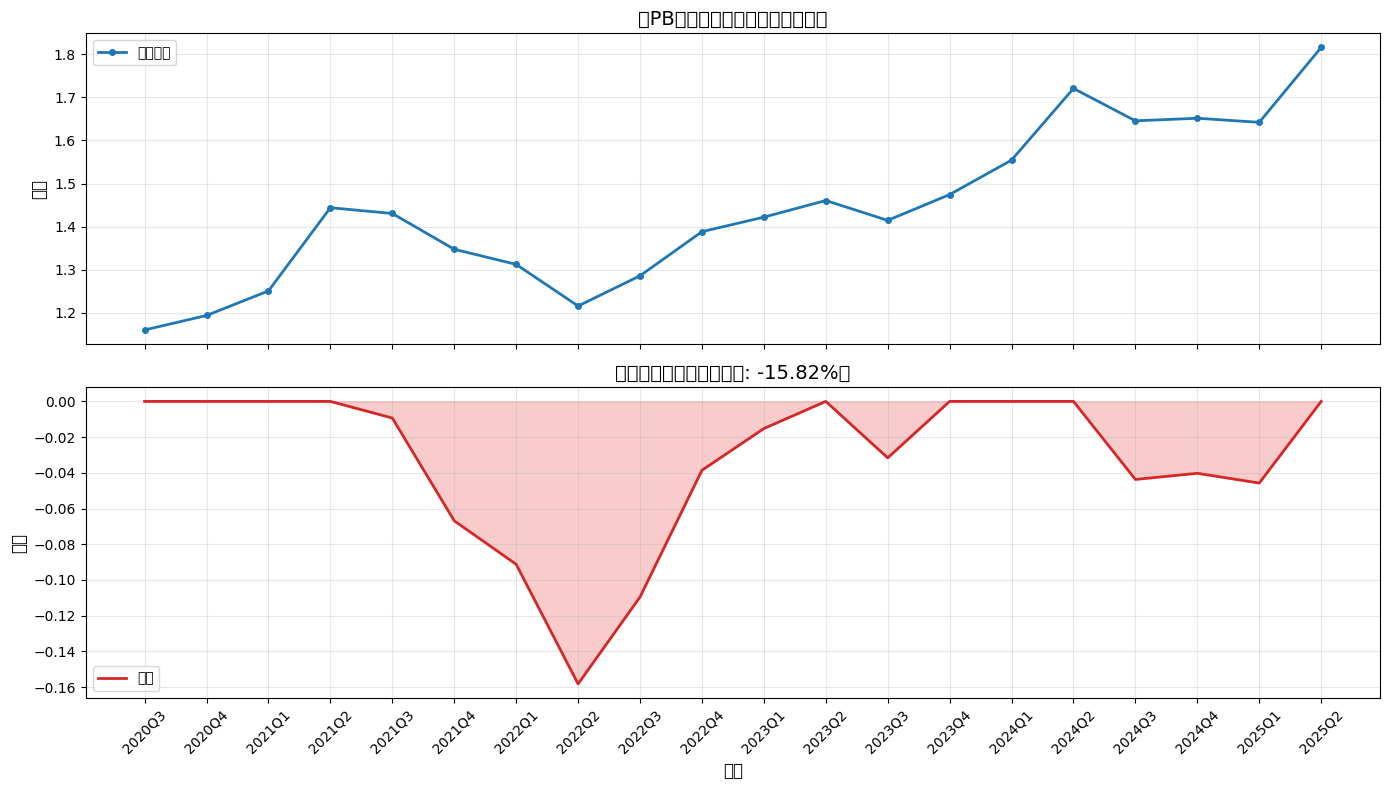

In [79]:
# ========================
# 2. 绘图：净值曲线 + 回撤
# ========================
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# 净值曲线
axes[0].plot(net_value.index.astype(str), net_value.values, label='净值曲线', color='tab:blue', linewidth=2, marker='o', markersize=4)
axes[0].set_title('低PB策略净值曲线（季度再平衡）', fontsize=14)
axes[0].set_ylabel('净值', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# 回撤曲线
axes[1].plot(drawdown.index.astype(str), drawdown.values, label='回撤', color='tab:red', linewidth=2)
axes[1].fill_between(drawdown.index.astype(str), drawdown.values, 0, color='lightcoral', alpha=0.4)
axes[1].set_title(f'策略回撤曲线（最大回撤: {max_drawdown:.2%}）', fontsize=14)
axes[1].set_ylabel('回撤', fontsize=12)
axes[1].set_xlabel('季度', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# 旋转 x 轴标签
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [112]:
import pandas as pd
import numpy as np

# 设置时间范围：最近5年
today = pd.Timestamp.now()
five_years_ago = today - pd.DateOffset(years=5)

# ========================
# 1. 从 price_cache 构建周频数据，并限制为近5年
# ========================
rows = []
for code, series in price_cache.items():
    if series.empty:
        continue
    
    # 过滤近5年
    series = series[series.index >= five_years_ago]
    if len(series) < 10:
        continue
    
    # 转周频
    weekly = series.resample('W').last()  # 返回 Series
    df = weekly.to_frame(name='close').reset_index()  # 强制重置 index
    df['code'] = code
    rows.append(df)

# 合并后，重新设置一个干净的整数索引 或 用 (date, code) 多重索引
full_df = pd.concat(rows, ignore_index=True)  # ✅ 关键：ignore_index=True

# 然后设置 date 为索引（但确保唯一）
full_df['date'] = pd.to_datetime(full_df['date'])
full_df.sort_values(['code', 'date'], inplace=True)

# ✅ 方法一：使用整数索引（推荐）
# full_df.set_index('date', inplace=True)  # 不设为索引，避免 reindex 冲突

# ✅ 方法二：使用多重索引（更安全）
full_df.set_index(['date', 'code'], inplace=True)

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ========================
# 配置参数
# ========================
YEARS = 5
MOMENTUM_WEEKS = 12
MIN_MOMENTUM = -0.3  # 过去12周跌幅不超过50%
TOP_N = 12

# 时间范围
today = pd.Timestamp.now()
start_date = today - pd.DateOffset(years=YEARS)

# ========================
# Step 1: 从 price_cache 构建 full_df（近5年，避免重复索引）
# ========================
rows = []
for code, series in price_cache.items():
    if series.empty:
        continue
    # 过滤时间
    series = series[series.index >= start_date]
    if len(series) < 10:
        continue
    # 转为周频：取每周最后一个交易日
    weekly = series.resample('W').last()  # 得到 Series
    df = weekly.to_frame(name='close').reset_index()
    df.columns = ['date', 'close']
    df['code'] = code
    rows.append(df)

# 合并并重置索引，避免 duplicate label 问题
if not rows:
    raise ValueError("❌ 无有效价格数据（近5年）")

full_df = pd.concat(rows, ignore_index=True)
full_df['date'] = pd.to_datetime(full_df['date'])
full_df.sort_values(['code', 'date'], inplace=True)

# 添加 week 标签
full_df['week'] = full_df['date'].dt.to_period('W')

# ========================
# Step 2: 计算周收益 & 12周动量（向量化）
# ========================
# 排序确保 shift 正确
full_df.sort_values(['code', 'date'], inplace=True)

# 周收益
full_df['return'] = full_df.groupby('code')['close'].pct_change()
full_df.dropna(subset=['return'], inplace=True)

# 12周前价格 → 12周动量
full_df['close_12w_ago'] = full_df.groupby('code')['close'].shift(MOMENTUM_WEEKS)
full_df['momentum_12w'] = (full_df['close'] / full_df['close_12w_ago']) - 1

# 动量过滤：排除过去12周跌幅超过50%的股票
filtered_df = full_df[full_df['momentum_12w'] > MIN_MOMENTUM].copy()

# ========================
# Step 3: 每周选出“当周涨幅最低的10只股票”
# ========================
# 确保每周每只股票只保留一条（取最后一天）
weekly_data = filtered_df.groupby(['week', 'code']).last().reset_index()

# 每周选涨幅最小的10只
def select_lowest_10(group):
    return group.nsmallest(TOP_N, 'return')

selected_weekly = weekly_data.groupby('week').apply(select_lowest_10)
selected_weekly = selected_weekly.reset_index(drop=True)

# ========================
# Step 4: 向量化获取“下一周收益”
# ========================
#  确保 weekly_data 是普通 DataFrame（code, week 是列）
weekly_data_flat = weekly_data.reset_index()  # 确保 code 和 week 是列

# selected_with_next 的 week 必须是列（不是索引）
selected_with_next = selected_weekly[['code', 'week']].copy()  # 这里 week 是列
selected_with_next['next_week'] = selected_with_next['week'] + 1

# 合并：找这些股票在“下一周”的收益
future_returns = pd.merge(
    selected_with_next,
    weekly_data_flat[['code', 'week', 'return']],
    left_on=['code', 'next_week'],
    right_on=['code', 'week'],
    how='left'
).rename(columns={'return': 'future_return'})

future_returns = future_returns.rename(columns={'week_x': 'week'})

# 删除 week_y（它是 next_week 的副本）
future_returns = future_returns.drop(columns=['week_y'])

In [149]:
# ========================
# Step 5: 按买入周统计收益
# ========================
strategy_return = future_returns.groupby('week')['future_return'].mean().dropna()

# 净值曲线
net_value = (1 + strategy_return).cumprod()

# 最大回撤
peak = net_value.expanding().max()
drawdown = (net_value - peak) / peak
max_drawdown = drawdown.min()

# 年化指标
annual_return = (1 + strategy_return.mean()) ** 52 - 1
weekly_volatility = strategy_return.std()
sharpe_ratio = (strategy_return.mean() / weekly_volatility) * np.sqrt(52)  # ✅ 52周
win_rate = (strategy_return > 0).mean()
max_drawdown = drawdown.min()

# 输出
print("\n" + "="*40)
print("       策略回测结果（近5年）")
print("="*40)
print(f"回测周期: {start_date.date()} ~ {today.date()}")
print(f"总周数: {len(strategy_return)}")
print(f"平均周收益: {strategy_return.mean():.2%}")
print(f"年化收益率: {annual_return:.2%}")
print(f"胜率: {win_rate:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")


       策略回测结果（近5年）
回测周期: 2020-08-26 ~ 2025-08-26
总周数: 228
平均周收益: 0.30%
年化收益率: 16.61%
胜率: 53.51%
最大回撤: -16.05%
夏普比率: 0.80


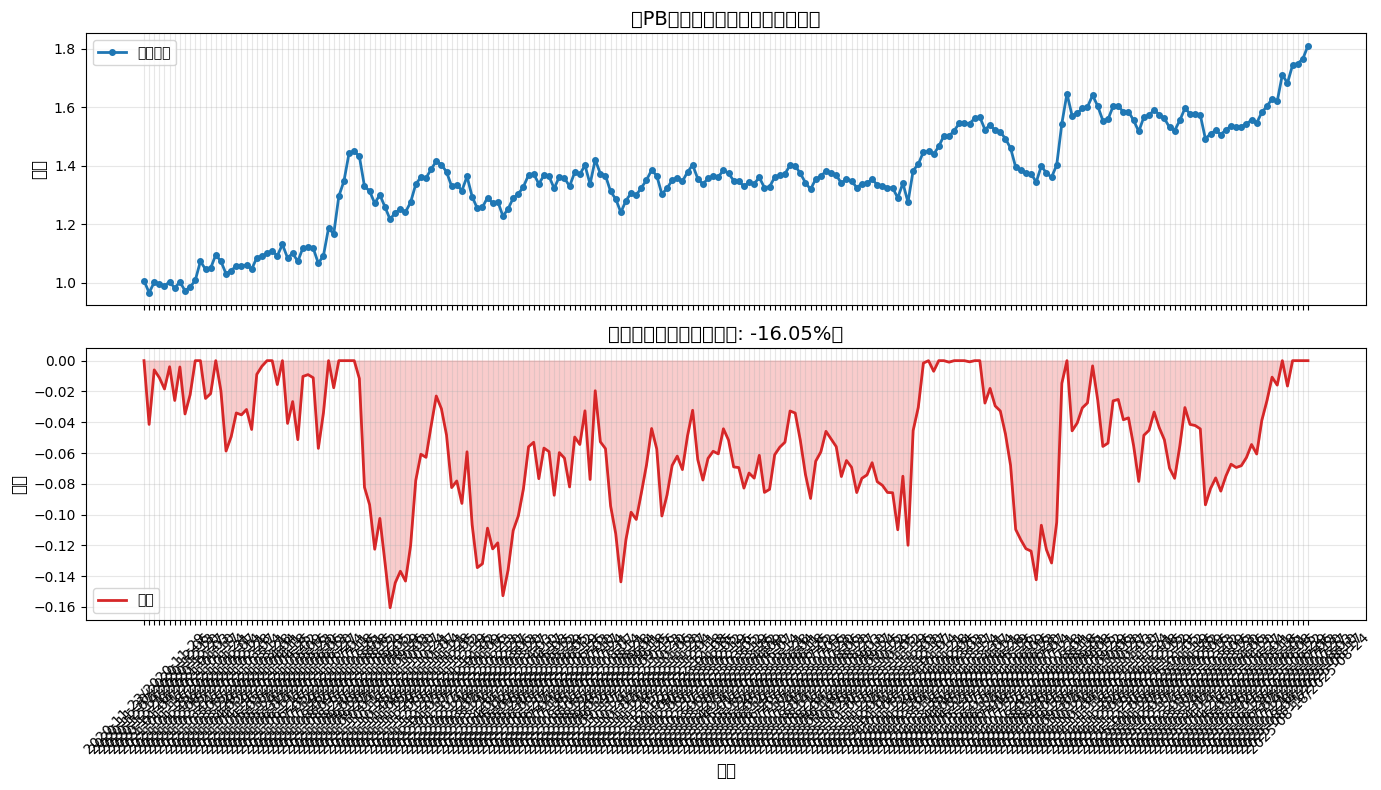

In [151]:
# ========================
# 2. 绘图：净值曲线 + 回撤
# ========================
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# 净值曲线
axes[0].plot(net_value.index.astype(str), net_value.values, label='净值曲线', color='tab:blue', linewidth=2, marker='o', markersize=4)
axes[0].set_title('低PB策略净值曲线（季度再平衡）', fontsize=14)
axes[0].set_ylabel('净值', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# 回撤曲线
axes[1].plot(drawdown.index.astype(str), drawdown.values, label='回撤', color='tab:red', linewidth=2)
axes[1].fill_between(drawdown.index.astype(str), drawdown.values, 0, color='lightcoral', alpha=0.4)
axes[1].set_title(f'策略回撤曲线（最大回撤: {max_drawdown:.2%}）', fontsize=14)
axes[1].set_ylabel('回撤', fontsize=12)
axes[1].set_xlabel('季度', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# 旋转 x 轴标签
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()